### Dependencies

In [1]:
#!pip install Keras
#!pip install tensorflow
#!pip install attention

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wavlet import WT,snr

### Read data and set date column as index

In [3]:
df= pd.read_excel('dataset/Agricultural_development_bank_limited.xlsx', index_col=1)
df.drop('S.N.', axis=1, inplace=True)
df.index = pd.to_datetime(df.index)

In [4]:
df.head(3)

,Open,High,Low,Close,Volume,Turnover
Date,,,,,,
2011-03-20,132,134,131,133,1507,198979
2011-03-24,135,136,129,133,3116,415035
2011-03-25,133,135,132,135,2560,342820


### Perform wavlet transform to all data columns to reduce noise

In [5]:
X=[]
sn=0
i=0
for col in df.columns:
    pred = np.sum(WT(df[col], wavefunc='coif4',plot=False), axis=0)
    X.append(pred)
    sn = sn + snr(df[col].to_numpy(),pred)
    i = i+1
d_clean = pd.DataFrame(data={'Open': X[0], 'High': X[1], 'Low':X[2],'Close':X[3],'Volume':X[4],'Turnover':X[5]}, index = df.index)
print(f'Average SNR: {sn/i}')

Average SNR: 19.981927536339054


### Visualization of denoised data (500 sample data)

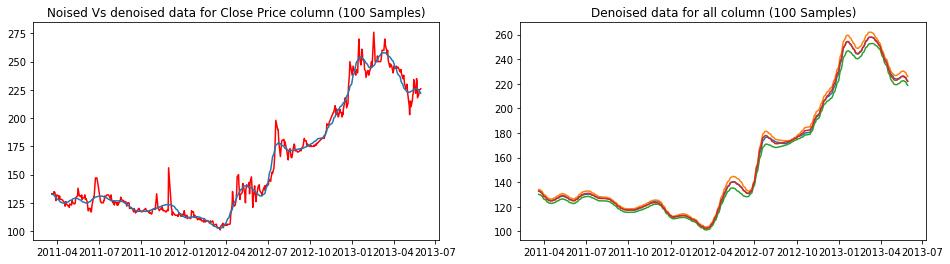

In [6]:
fig, axs = plt.subplots(1,2, figsize = (16,4))
axs[0].plot(df['Close'][:500], 'r-', d_clean['Close'][:500])
axs[0].set_title("Noised Vs denoised data for Close Price column (100 Samples)")

axs[1].plot(d_clean[['Open','High','Low','Close']][:500])
axs[1].set_title("Denoised data for all column (100 Samples)")
plt.show()

### Open, High, Low and Close price history (Denoised)

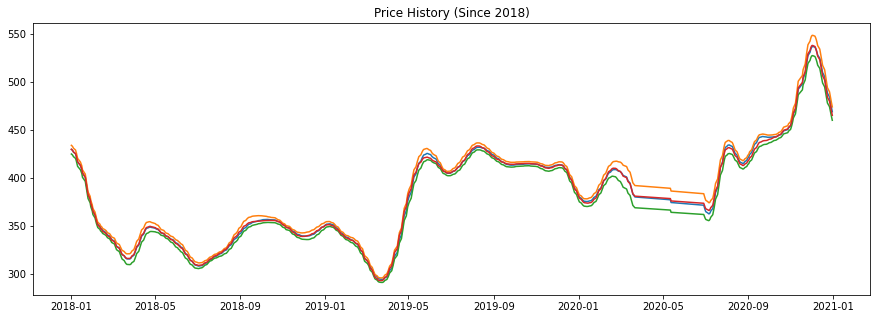

In [7]:
plt.figure(figsize = (15, 5))
plt.title('Price History (Since 2018)')
plt.plot(d_clean[['Open','High','Low','Close']]['2018-01-01':'2021-01-01']);

### Taking only Close values for training and prediction

In [8]:
data = d_clean.filter(['Close']).values

### Data normalization (minmax scaling)

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
s_data = scaler.fit_transform(data)

### Train test (80-20) sequence split taking 60 past sequences as feature vector

In [10]:
import math
t_len = math.ceil(len(data) * .8)
train_data = s_data[0:t_len, :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i,0])

### Training data size

In [11]:
print(f'Training data X shape: {np.shape(x_train)} \nTraining data Y shape: {np.shape(y_train)}')

Training data X shape: (1718, 60) 
Training data Y shape: (1718,)


### Reshape 2D training data into 3D (LSTM takes 3D data as input)

In [12]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1718, 60, 1)

### Preparing LSTM with Attention model

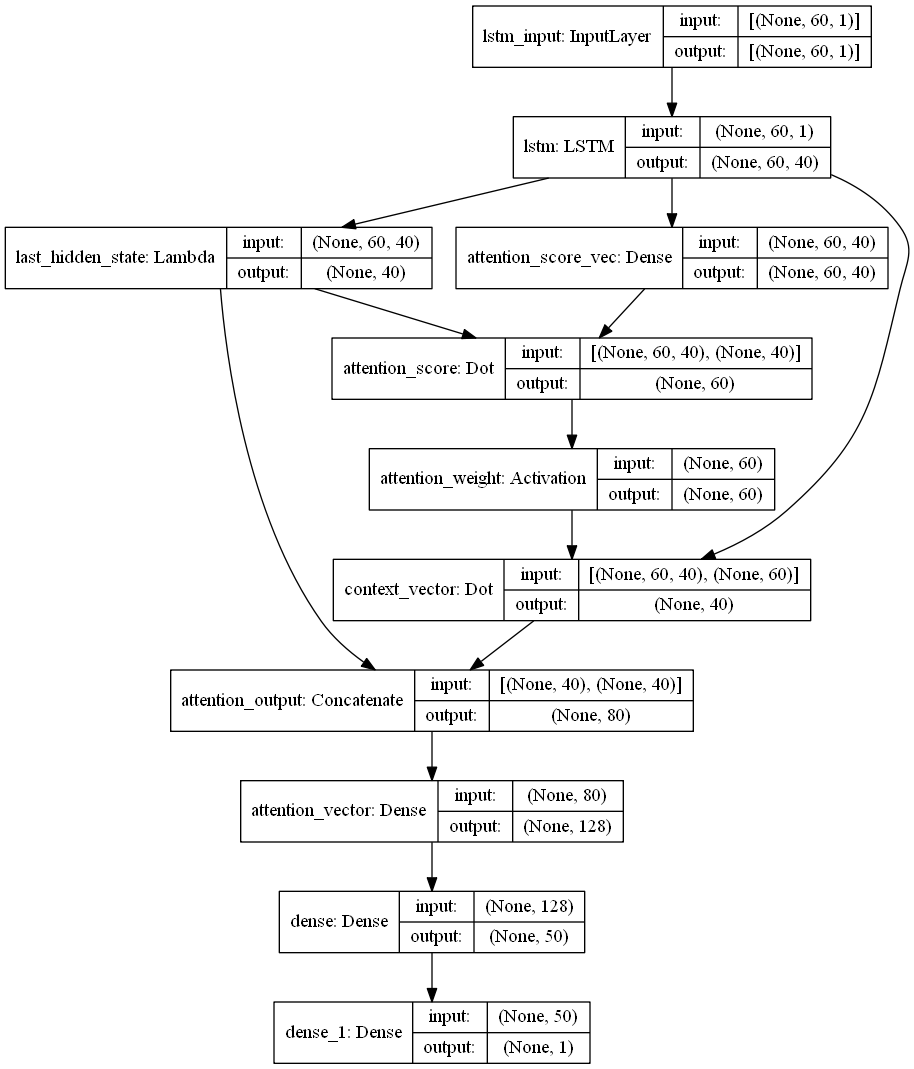

In [13]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras_self_attention import SeqSelfAttention
from attention import Attention
from keras.utils.vis_utils import plot_model

model = Sequential([
        LSTM(40, input_shape=(x_train.shape[1], 1), return_sequences=True),
        Attention(),
        Dense(50, activation = 'sigmoid'),
        Dense(1, activation = 'linear')
    ])
plot_model(model, to_file='cmdmodel_plot.png', show_shapes=True, show_layer_names=True)

### Training the model

In [14]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
History = model.fit(x_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
54/54 [==============================] - 2s 10ms/step - loss: 0.0230
Epoch 2/100
54/54 [==============================] - 1s 9ms/step - loss: 0.0011
Epoch 3/100
54/54 [==============================] - 0s 9ms/step - loss: 3.8105e-04
Epoch 4/100
54/54 [==============================] - 1s 9ms/step - loss: 1.6620e-04
Epoch 5/100
54/54 [==============================] - 1s 10ms/step - loss: 1.3673e-04
Epoch 6/100
54/54 [==============================] - 1s 10ms/step - loss: 9.3129e-05
Epoch 7/100
54/54 [==============================] - 1s 10ms/step - loss: 7.1730e-05
Epoch 8/100
54/54 [==============================] - 1s 9ms/step - loss: 5.9893e-05
Epoch 9/100
54/54 [==============================] - 1s 10ms/step - loss: 7.4645e-05
Epoch 10/100
54/54 [==============================] - 0s 9ms/step - loss: 6.6953e-05
Epoch 11/100
54/54 [==============================] - 1s 9ms/step - loss: 4.2331e-05
Epoch 12/100
54/54 [==============================] - 0s 9ms/step - loss: 3.9

54/54 [==============================] - 0s 9ms/step - loss: 5.7043e-06
Epoch 98/100
54/54 [==============================] - 0s 9ms/step - loss: 8.5267e-06
Epoch 99/100
54/54 [==============================] - 0s 9ms/step - loss: 9.7032e-06
Epoch 100/100
54/54 [==============================] - 0s 9ms/step - loss: 4.4923e-06


### Training loss graph

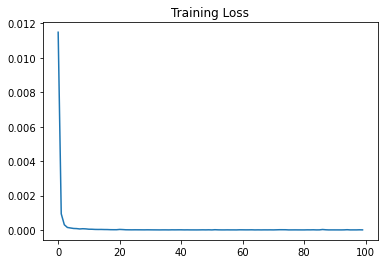

In [15]:
plt.plot(History.history['loss'][:], label='Training loss');
plt.title('Training Loss');

### Test data preparation

In [16]:
test_data = s_data[t_len-60: , :]
x_test = []
y_test = data[t_len: , :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

### Predict for test data

In [17]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

### RMSE error

In [18]:
print(np.sqrt(np.mean(predictions - y_test)**2))

3.5026474660574984


### Visualization of training and predicted graph

<ipython-input-19-c10d0f2daa1c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


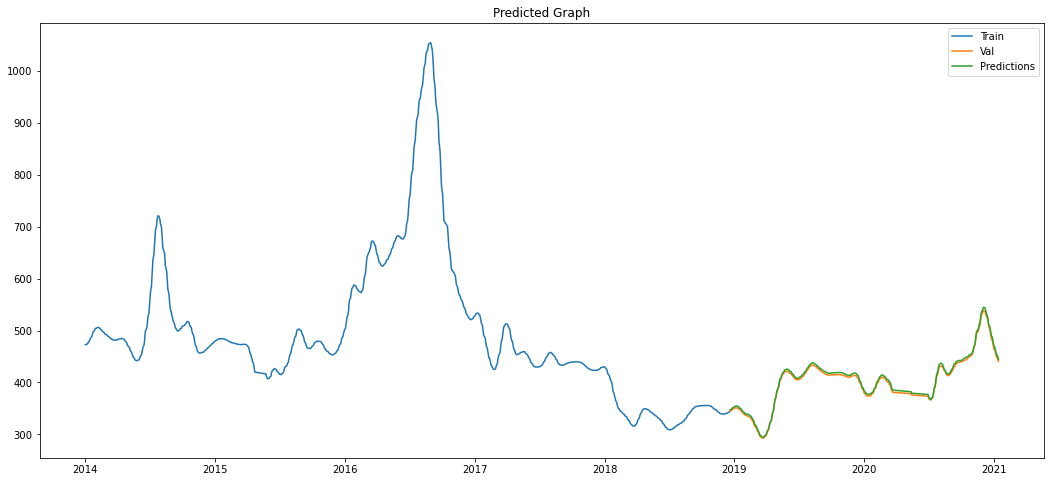

In [19]:
### RMSE errorplt.style.use('ggplot')

train = d_clean[:t_len]
valid = d_clean[t_len:]
valid['Predictions'] = predictions
plt.figure(figsize = (18,8))
plt.plot(train['Close']['20140101':])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'])
plt.title('Predicted Graph');

### Close up look of prediction for 2019 to 2020

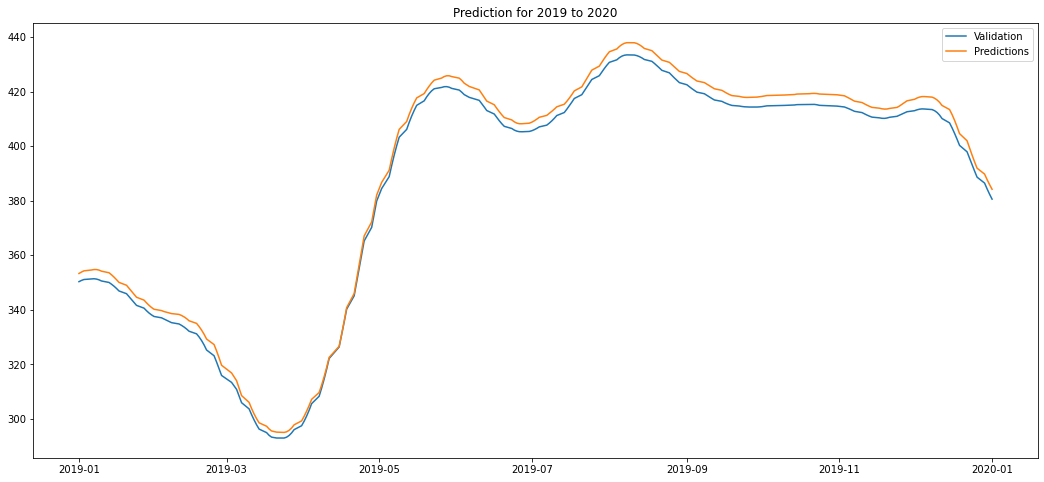

In [20]:
plt.figure(figsize = (18,8))
plt.plot(valid[['Close', 'Predictions']]['20190101':'20200101']);
plt.legend(['Validation', 'Predictions'])
plt.title('Prediction for 2019 to 2020');